[Blog to Refer](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

## Imports

In [1]:
# data manulplation
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# statstical testing
from scipy import stats

# train test split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# metrcs
from sklearn.metrics import f1_score

# general
import os
from typing import List
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [10]:
DATA_DIR = r"Dataset\2_processed_data\train_iteratoin4.csv"
df = pd.read_csv(DATA_DIR)

In [11]:
df.shape

(891, 33)

In [12]:
df.head()

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,...,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
0,0,4,23,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,1,0,0.343160,1.906724
1,1,7,51,13,2.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.0,0.0,1,1,0,0.542804,3.497640
2,1,3,22,9,1.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.395247,1.970459
3,1,7,44,13,2.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,1,1,0,0.506943,3.304258
4,0,4,24,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.506943,1.981680


In [13]:
df.columns

Index(['Survived', 'Name_Words', 'Name_Length', 'Name_Init_labelencode',
       'Name_Init_ordinalencode', 'Name_Init_capt', 'Name_Init_col',
       'Name_Init_countess', 'Name_Init_don', 'Name_Init_dr',
       'Name_Init_jonkheer', 'Name_Init_lady', 'Name_Init_major',
       'Name_Init_master', 'Name_Init_miss', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms', 'Name_Init_rev',
       'Name_Init_sir', 'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass', 'SibSp', 'Parch', 'Age_Power_MinMax', 'Fare_Power'],
      dtype='object')

In [7]:
# df.info()

In [81]:
TARGET_COL = ["Survived"]
NUM_FATURES = ["Name_Words", "Name_Length",  'SibSp', 'Parch', 'Age_Power_MinMax', 'Fare_Power']
CAT_FEATURES = ["Name_Init_labelencode", "Name_Init_ordinalencode",'Name_Init_capt', 'Name_Init_col',
       'Name_Init_countess', 'Name_Init_don', 'Name_Init_dr',
       'Name_Init_jonkheer', 'Name_Init_lady', 'Name_Init_major',
       'Name_Init_master', 'Name_Init_miss', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms', 'Name_Init_rev',
       'Name_Init_sir', 'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass']

# Feature Selection

## Filter Methods

In [15]:
# Define custom colors and boundaries
colors = ['#0D47A1', '#1976D2', '#64B5F6', '#90CAF9',  # Blue shades for positive values
          '#FFEB3B', '#FFC107', '#FF9800', '#F57C00']  # Orange shades for negative values

In [16]:
def highlight_scores(value):
    # print(value)
    if value > 0:
        if value >= 0.75: # 0.76 to 1.0
            return f'background-color: {colors[0]}; color: green'
        elif value >= 0.50: # 0.51 to 0.75 
            return f'background-color: {colors[1]}; color: black'
        elif value >= 0.25: # 0.26 to 0.50
            return f'background-color: {colors[2]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {colors[3]}; color: red'
    else:
        if  value >=-0.25 : # 0.0 to -0.25 
            return f'background-color: {colors[4]}; color: red'
        elif value >= -0.50: # -0.26 to -0.50
            return f'background-color: {colors[5]}; color: black'
        elif value >= -0.75: # -0.51 to -0.75
            return f'background-color: {colors[6]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {colors[7]}; color: green'

#### Removing Less Correlated features with Target

```
Corr(feature_1 X Target)    = 0.39 # drop
Corr(feature_2 X Target)    = 0.65 

threshold = 0.4
```
**Solution:**

- To reduce garbage will drop `feature_1` 


In [17]:
# find features have high correlation with target variable
def correlation_with_target(corr_df:pd.DataFrame, target:str, threshold: float, add_neg=True):
    """ 
    this function is to filter the columns which has high correlation with target
    greater than mentioned threshold, also if we want to add highly correlated
    negative features, then we can get those by `add_neg=True` (default)
    """
    corr_columns = {}
    for column in corr_df.columns:
        if column not in [target]:
            corr_val = np.round(corr_df[column].iloc[0], 3)
            if corr_val > 0: # if positive
                if corr_val > threshold:
                    corr_columns.update({column: corr_val})
            elif add_neg == True:
                if corr_val < -threshold:
                    corr_columns.update({column: corr_val})
    return corr_columns

#### Removing Inter-Correlated features

**Case 1 :**

```
Corr(feature_1 X Target)    = 0.39 # drop
Corr(feature_2 X Target)    = 0.45 

Corr(feature_1 X feature_2) = 0.75 
```
**Solution:**

- To reduce inter-correlation will drop `feature_1` 
- and adding `feature_2` into list 

**Case 2 :**

```
Corr(feature_3 X Target)    = 0.55 

Corr(feature_2 X feature_3) = 0.85 
```
**Conflict:**

- `feature_2` already exists in list
- 1st we have to drop `feature_2`
- now we have to add `feature_3` in list


In [18]:
# eliminate features which has high inter correlation with features other than target
def inter_correlation_eleimination(corr_df:pd.DataFrame, target:str, max_inter_corr_thre:float):
    """ 
    this function is to filter the columns which has high correlation with other
    independent features, also it will take care of negatively correlated features
    and return list of features which has no inter correlation (aim is to get features
    which are independent to each other)

    Example:

    feature_1 -> target : corr_1 = 0.5
    feature_2 -> target : corr_2 = 0.8
    
    feature_1 <-> feature_2 : inter_corr = - 0.7

    max_inter_corr_thre = 0.5

    if abs(inter_corr) > max_inter_corr_thre :
        return max { abs(corr_1), abs(corr_2) }
    
    then will eliminate : feature_1
    """
    independent_columns = {}
    # skipping target
    columns = corr_df.columns.to_list()
        
    for feature_1 in columns:
        if feature_1 not in [target]:
            corr_val_feature_1 = np.round(corr_df[target].iloc[0], 3) # feature_1 -> target
            for index_f2, feature_2 in enumerate(columns):
                if feature_2 not in [feature_1, target]:
                    corr_val_feature_2 = np.round(corr_df[feature_2].iloc[0], 3) # feature_2 -> target
                    
                    inter_corr_f1_f2 = np.round(corr_df[feature_2].iloc[index_f2], 3) # row: feature_1, column: feature_2

                    # only less inter_correlated features than threshold
                    if np.abs(inter_corr_f1_f2) < max_inter_corr_thre:
                        if np.abs(corr_val_feature_1) > np.abs(corr_val_feature_2):
                            # drop feature_2 if it exisis in list
                            # if feature_2 in independent_columns.keys():
                            #     del independent_columns[feature_2]
                            # else:
                            independent_columns.update({feature_1: corr_val_feature_1})
                        else:
                            # drop feature_2 if it exisis in list
                            # if feature_1 in independent_columns.keys():
                            #     del independent_columns[feature_1]
                            # else:
                            independent_columns.update({feature_2: corr_val_feature_2})
    return independent_columns

#### Stats-Test Filtters :

In [12]:
# possible statstical method to filter all combination of feature and target
def statistical_filtering(df:pd.DataFrame, num_features:List[str], cat_features:List[str], target:List[str]):
    """
    this function will filter numerical and categorical variables
    based on statstical test score if there is a significance 
    """
    report_df = pd.DataFrame()
    filtered_num_col = []
    filtered_cat_cols = []

    # numrical features: int -> cat | float -> cat
    
    # check normality

    # parametric

    # non parametricsss

    # add to report

    # filter num columns

    # categorical features: binary -> cat | ordinal -> cat | nominal -> cat
    for column in cat_features:
        unique = df[column].nunique()
        if unique > 2:
            pass
            # parametric
            # non parametric
        else:
            pass 
            # parametric
            # non parametric

    # add to report

    # filter cat columns

    return filtered_num_col, filtered_cat_cols, report_df

### Correlation Coefficient :

In [19]:
df_corr_person = df.corr(method='pearson') # assumption : if data had linear relation : parametric
df_corr_kendall = df.corr(method='kendall') # two categorical variables
df_corr_spearman = df.corr(method='spearman') # assumption : if data had non linear relation : non-parametric


In [20]:
df_corr_person.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,Name_Init_lady,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
Survived,1.000000,0.276512,0.332350,-0.201345,0.294715,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.167675,0.106811,0.168240,0.003650,-0.149683,-0.338481,-0.035322,0.081629,-0.074320,0.326914
Name_Words,0.276512,1.000000,0.922586,0.193669,0.295847,-0.001932,-0.023035,0.112842,-0.001932,-0.037775,-0.001932,0.112842,-0.002734,-0.007858,-0.124525,0.037868,-0.001932,-0.353938,0.637876,-0.030626,-0.016493,0.084148,-0.375778,0.031348,-0.117474,0.021336,-0.147658,0.074230,-0.221348,0.141757,0.215977,0.063561,0.265729
Name_Length,0.332350,0.922586,1.000000,0.099694,0.365015,0.003739,-0.010048,0.104917,-0.010715,-0.027074,0.014580,0.137438,0.023187,0.053399,-0.042814,0.035970,0.007353,-0.456480,0.638699,-0.007101,-0.008567,0.061555,-0.448759,0.022885,-0.107749,0.027481,-0.140941,0.064620,-0.220001,0.165019,0.252282,0.034057,0.274752
Name_Init_labelencode,-0.201345,0.193669,0.099694,1.000000,-0.405843,-0.201798,-0.260099,-0.165831,-0.147847,-0.344750,-0.111879,-0.093895,-0.107416,-0.374668,-0.603751,-0.031074,-0.003976,0.491325,0.385540,0.049975,0.166935,0.085943,0.256407,0.066462,-0.122448,-0.023314,-0.122203,0.097327,0.045541,-0.191786,-0.119721,0.299538,-0.116789
Name_Init_ordinalencode,0.294715,0.295847,0.365015,-0.405843,1.000000,0.192735,0.213150,0.171685,0.297986,0.176364,0.319036,0.255886,0.183364,0.293539,0.049636,0.153578,0.276936,-0.623161,0.293258,0.213786,0.214897,0.234836,-0.339311,-0.093935,0.050181,0.099480,-0.012511,-0.079275,-0.212640,0.155206,0.175888,-0.019438,0.204919
Name_Init_capt,-0.026456,-0.001932,0.003739,-0.201798,0.192735,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.019641,-0.019067,-0.016158,-0.010310,0.020643,-0.052496,0.014507,0.025731,0.094827,0.044684
Name_Init_col,0.011329,-0.023035,-0.010048,-0.260099,0.213150,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.032167,0.010348,0.037766,-0.014588,-0.023904,-0.074282,-0.022508,-0.022467,0.097468,0.026063
Name_Init_countess,0.042470,0.112842,0.104917,-0.165831,0.171685,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.019641,-0.019067,-0.016158,-0.010310,0.020643,-0.052496,-0.015907,-0.015878,0.010767,0.050618
Name_Init_don,-0.026456,-0.001932,-0.010715,-0.147847,0.297986,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.065106,0.033694,0.069538,-0.010310,-0.054430,-0.052496,-0.015907,-0.015878,0.027750,0.015138
Name_Init_dr,0.008185,-0.037775,-0.027074,-0.344750,0.176364,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.028208,0.029419,0.022104,0.017874,-0.030612,-0.108935,0.003910,-0.042150,0.071487,0.056303


In [24]:
## capture columns with high correlation with target
pearson_features = set(correlation_with_target(df_corr_person, "Survived", 0.3).keys())

In [25]:
pearson_features

{'Fare_Power',
 'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Length',
 'Pclass',
 'Sex_labelencode'}

In [26]:
df_corr_kendall.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,Name_Init_lady,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
Survived,1.000000,0.218077,0.254681,-0.081571,0.483828,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.155747,0.132087,0.168240,0.003650,-0.149683,-0.323533,0.085915,0.133933,-0.031055,0.266229
Name_Words,0.218077,1.000000,0.772030,0.256211,0.311830,0.006992,-0.021896,0.056846,0.006992,-0.032559,0.006992,0.056846,0.009894,0.021367,-0.086387,0.011223,0.006992,-0.281975,0.483035,-0.037940,-0.006759,0.053803,-0.285649,0.104597,-0.132372,-0.029916,-0.154178,0.123232,-0.195132,0.253047,0.220443,0.022368,0.221703
Name_Length,0.254681,0.772030,1.000000,0.123827,0.376856,0.014450,-0.009416,0.047586,-0.006953,-0.013144,0.025911,0.048129,0.037856,0.082794,0.020996,0.014451,0.018524,-0.361098,0.417389,-0.001630,0.006271,0.041013,-0.331131,0.069712,-0.097410,-0.008044,-0.126905,0.086908,-0.171896,0.243909,0.221290,-0.010721,0.206440
Name_Init_labelencode,-0.081571,0.256211,0.123827,1.000000,-0.201030,-0.061143,-0.086226,-0.060730,-0.060593,-0.159398,-0.059494,-0.059356,-0.083698,-0.363913,-0.619920,-0.040148,-0.028167,0.260245,0.620941,0.060181,0.149009,0.061143,0.086121,0.063639,-0.095023,0.005422,-0.138661,0.082509,-0.058717,-0.010587,-0.115206,0.289514,-0.007265
Name_Init_ordinalencode,0.483828,0.311830,0.376856,-0.201030,1.000000,0.060318,0.084865,0.060181,0.061005,0.153927,0.061143,0.060730,0.084476,0.354138,0.337477,0.084087,0.060868,-0.901218,0.523246,0.060456,0.144622,0.060593,-0.694563,-0.083016,0.079331,0.070380,0.036184,-0.084426,-0.156041,0.307525,0.359764,-0.087882,0.275251
Name_Init_capt,-0.026456,0.006992,0.014450,-0.061143,0.060318,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.019848,-0.019848,-0.016158,-0.010310,0.020643,-0.046561,0.041114,0.049335,0.048357,0.036608
Name_Init_col,0.011329,-0.021896,-0.009416,-0.086226,0.084865,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.027397,0.018570,0.037766,-0.014588,-0.023904,-0.065884,-0.030831,-0.025505,0.064611,0.031740
Name_Init_countess,0.042470,0.056846,0.047586,-0.060730,0.060181,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.019848,-0.019848,-0.016158,-0.010310,0.020643,-0.046561,-0.021789,-0.018025,0.020575,0.040842
Name_Init_don,-0.026456,0.006992,-0.006953,-0.060593,0.061005,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.058571,0.046095,0.069538,-0.010310,-0.054430,-0.046561,-0.021789,-0.018025,0.031798,0.019403
Name_Init_dr,0.008185,-0.032559,-0.013144,-0.159398,0.153927,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.029003,0.029863,0.022104,0.017874,-0.030612,-0.102678,0.003708,-0.047851,0.059440,0.052383


In [27]:
## capture columns with high correlation with target
kendall_features = set(correlation_with_target(df_corr_kendall, "Survived", 0.3))

In [28]:
kendall_features

{'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Init_ordinalencode',
 'Pclass',
 'Sex_labelencode'}

In [29]:
df_corr_spearman.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,Name_Init_lady,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
Survived,1.000000,0.234616,0.305809,-0.086869,0.515248,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.160196,0.135861,0.168240,0.003650,-0.149683,-0.339668,0.088879,0.138266,-0.037004,0.323736
Name_Words,0.234616,1.000000,0.880472,0.297565,0.356879,0.007523,-0.023556,0.061157,0.007523,-0.035028,0.007523,0.061157,0.010645,0.022987,-0.092938,0.012074,0.007523,-0.303359,0.519667,-0.040817,-0.007272,0.057883,-0.307312,0.114058,-0.148167,-0.032185,-0.165870,0.132578,-0.220829,0.285157,0.244629,0.031629,0.289798
Name_Length,0.305809,0.880472,1.000000,0.177046,0.475457,0.017350,-0.011306,0.057139,-0.008349,-0.015782,0.031113,0.057791,0.045456,0.099416,0.025211,0.017352,0.022242,-0.433589,0.501181,-0.001957,0.007531,0.049246,-0.397607,0.086044,-0.120360,-0.009659,-0.152381,0.104356,-0.216458,0.306576,0.273374,-0.011747,0.298848
Name_Init_labelencode,-0.086869,0.297565,0.177046,1.000000,-0.161030,-0.065113,-0.091825,-0.064674,-0.064528,-0.169750,-0.063357,-0.063211,-0.089134,-0.387546,-0.660178,-0.042755,-0.029996,0.277145,0.661266,0.064089,0.158686,0.065113,0.091714,0.069137,-0.104657,0.005774,-0.147665,0.087868,-0.064992,-0.019445,-0.127648,0.352187,-0.011270
Name_Init_ordinalencode,0.515248,0.356879,0.475457,-0.161030,1.000000,0.064235,0.090376,0.064089,0.064967,0.163923,0.065113,0.064674,0.089962,0.377136,0.359393,0.089548,0.064821,-0.959744,0.557227,0.064382,0.154014,0.064528,-0.739669,-0.090005,0.087825,0.074950,0.038534,-0.089909,-0.174481,0.338730,0.397939,-0.106670,0.357841
Name_Init_capt,-0.026456,0.007523,0.017350,-0.065113,0.064235,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.020415,-0.020415,-0.016158,-0.010310,0.020643,-0.048883,0.042532,0.050931,0.057622,0.044515
Name_Init_col,0.011329,-0.023556,-0.011306,-0.091825,0.090376,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.028180,0.019101,0.037766,-0.014588,-0.023904,-0.069170,-0.031895,-0.026330,0.076990,0.038596
Name_Init_countess,0.042470,0.061157,0.057139,-0.064674,0.064089,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.020415,-0.020415,-0.016158,-0.010310,0.020643,-0.048883,-0.022540,-0.018608,0.024517,0.049664
Name_Init_don,-0.026456,0.007523,-0.008349,-0.064528,0.064967,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.060245,0.047412,0.069538,-0.010310,-0.054430,-0.048883,-0.022540,-0.018608,0.037890,0.023594
Name_Init_dr,0.008185,-0.035028,-0.015782,-0.169750,0.163923,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.029831,0.030716,0.022104,0.017874,-0.030612,-0.107798,0.003836,-0.049399,0.070829,0.063698


In [30]:
## capture columns with high correlation with target
spearman_features = set(correlation_with_target(df_corr_spearman, "Survived", 0.3))

In [31]:
spearman_features

{'Fare_Power',
 'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Init_ordinalencode',
 'Name_Length',
 'Pclass',
 'Sex_labelencode'}

#### Union Features

In [32]:
corr_features = TARGET_COL+list(pearson_features .union(kendall_features).union(spearman_features))

In [33]:
corr_features

['Survived',
 'Name_Length',
 'Pclass',
 'Name_Init_ordinalencode',
 'Sex_labelencode',
 'Name_Init_mrs',
 'Name_Init_mr',
 'Fare_Power',
 'Name_Init_miss']

#### Eliminating Intercorrelated Features

In [41]:
def create_lower_triangular_mask(corr: pd.DataFrame, thresh:float = 40):
    # mask = np.triu(np.ones_like(corr, dtype=bool))
    mask = np.tril(np.ones_like(corr, dtype=bool))
    # shape of mask
    n = mask.shape[0]
    # Traverse the lower triangle
    for i in range(n):
        for j in range(i + 1):  # j goes from 0 to i (inclusive)
            val = np.abs(corr.iloc[i, j])
            if val > thresh and val < 100:
                mask[i][j] = False
    return mask

def check_correlation(df: pd.DataFrame, features: List[str], methods: List[str] = None, percent: bool = True) -> dict():
    # factor
    factor = 1
    if percent:
        factor = 100

    if methods is None:
        methods = ["pearson", "kendall", "spearman"]

    # calculating correlation
    corr = {}
    for method in methods:
        # round offing the correlation to 3 decimal places
        df_corr = np.round(df[features].corr(method=method) * factor, 3) # this counts fractional error
        corr[method] = df_corr

    return corr

def plot_correlation(corr_dict: dict(), width:int=15, height:int=4, thresh:float = 40) -> None:
    # collect no of methods
    no_of_methods = list(corr_dict.keys())
    # collect total columns
    list_of_columns = list(corr_dict[no_of_methods[0]].columns)

    # decide we have to plot horizontally or vertically
    if len(list_of_columns) > 11: 
        # go vertical 
        fig, axes = plt.subplots(len(no_of_methods), 1, figsize=(height, width))

        # plotting all the methods
        for row_idx, method_name in enumerate(no_of_methods):
            # generate mask based on threshold
            mask = create_lower_triangular_mask(corr_dict[method_name], thresh)
            sns.heatmap(corr_dict[method_name], annot=True,
                        square=True, # square in plot
                        cmap='coolwarm', # color system
                        cbar_kws={"shrink": .8},
                        mask=mask, # hididng upper tiangular 
                        annot_kws={"size": 10, "color": "black"},  # Customize font size and color
                        ax=axes[row_idx])

            axes[row_idx].set_title(f"{method_name} Correlation (%) | Min threshold: {thresh}")

        plt.tight_layout()
        plt.show()        

    else: 
        # go horizontal
        fig, axes = plt.subplots(1, len(no_of_methods), figsize=(width, height))

        # plotting all the methods
        for col_idx, method_name in enumerate(no_of_methods):
            # generate mask based on threshold
            mask = create_lower_triangular_mask(corr_dict[method_name], thresh)
            sns.heatmap(corr_dict[method_name], annot=True, 
                        square=True, # square in plot
                        cmap='coolwarm', # color system
                        cbar_kws={"shrink": .8},
                        mask=mask, # hididng upper tiangular 
                        annot_kws={"size": 10, "color": "black"},  # Customize font size and color
                        ax=axes[col_idx])
            axes[col_idx].set_title(f"{method_name} Correlation (%)| Min threshold: {thresh}")

        plt.tight_layout()
        plt.show()    

def highlight_scores(value, percent=True):
    # Define custom colors and boundaries
    positive_colors = ['#F08080', '#FA8072', '#FF6347', '#FF0000']
    negative_colors = ['#B0C4DE', '#4682B4', '#1E90FF', '#0000FF']
    
    # covert percent to float
    value = np.round(value/100,3)

    if value > 0:
        if value >= 0.75: # 0.76 to 1.0
            return f'background-color: {positive_colors[3]}; color: black'
        elif value >= 0.50: # 0.51 to 0.75 
            return f'background-color: {positive_colors[2]}; color: black'
        elif value >= 0.25: # 0.26 to 0.50
            return f'background-color: {positive_colors[1]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {positive_colors[0]}; color: black'
    else:
        if  value >=-0.25 : # 0.0 to -0.25 
            return f'background-color: {negative_colors[0]}; color: black'
        elif value >= -0.50: # -0.26 to -0.50
            return f'background-color: {negative_colors[1]}; color: black'
        elif value >= -0.75: # -0.51 to -0.75
            return f'background-color: {negative_colors[2]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {negative_colors[3]}; color: black'

def highlight_scores1(value):
    # Define custom colors and boundaries
    positive_colors = ['#F08080', '#FA8072', '#FF6347', '#FF0000']
    negative_colors = ['#B0C4DE', '#4682B4', '#1E90FF', '#0000FF']

    if value > 0:
        if value >= 75: # 0.76 to 1.0
            return f'background-color: {positive_colors[3]}; color: black'
        elif value >= 50: # 0.51 to 0.75 
            return f'background-color: {positive_colors[2]}; color: black'
        elif value >= 25: # 0.26 to 0.50
            return f'background-color: {positive_colors[1]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {positive_colors[0]}; color: black'
    else:
        if  value >=-25 : # 0.0 to -0.25 
            return f'background-color: {negative_colors[0]}; color: black'
        elif value >= -50: # -0.26 to -0.50
            return f'background-color: {negative_colors[1]}; color: black'
        elif value >= -75: # -0.51 to -0.75
            return f'background-color: {negative_colors[2]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {negative_colors[3]}; color: black'

def get_heatmap_dataframe(corr_dict: dict(), width:int=15, height:int=4, thresh:float = 40):
    pass

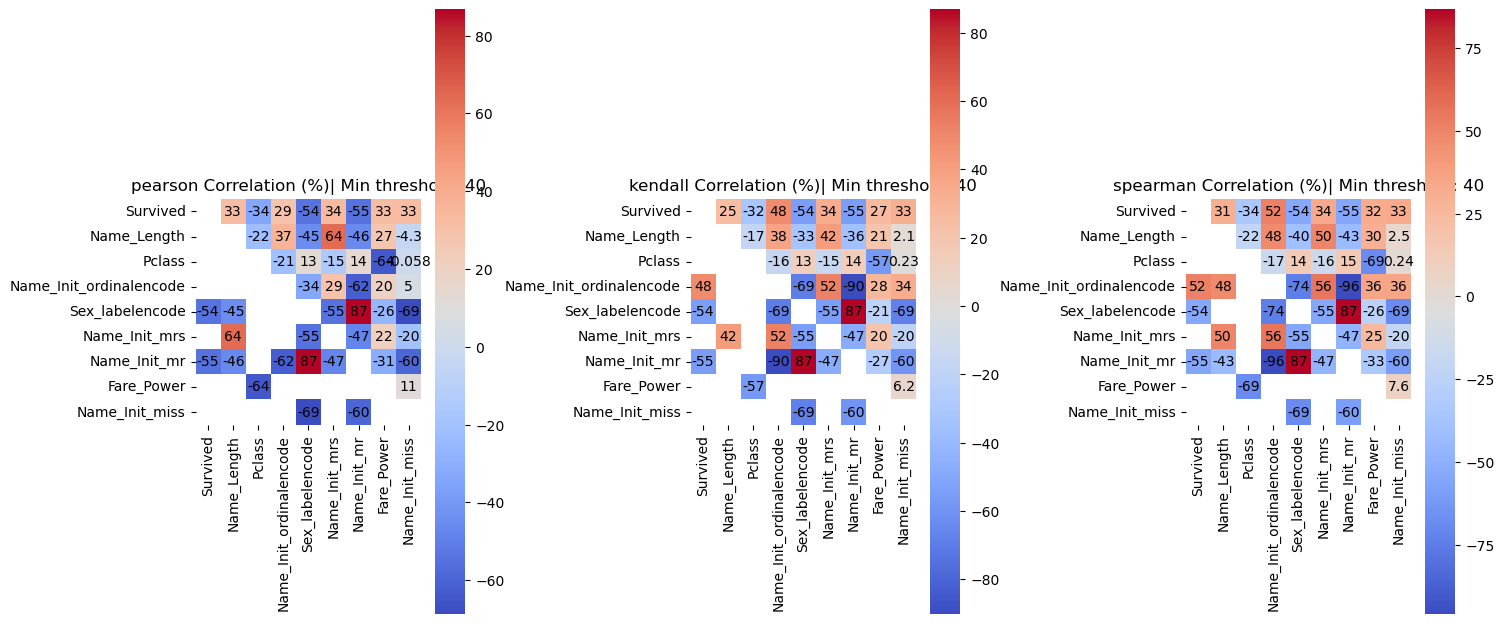

In [42]:
df_corr_person = check_correlation(df, corr_features)
plot_correlation(df_corr_person, 15, 8)

In [43]:
corr_features

['Survived',
 'Name_Length',
 'Pclass',
 'Name_Init_ordinalencode',
 'Sex_labelencode',
 'Name_Init_mrs',
 'Name_Init_mr',
 'Fare_Power',
 'Name_Init_miss']

### Statistical Tests : 
Select features based on statistical significance

## Wrapper Methods

[Blog to Refer](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)

In [9]:
# linear model
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
# Byes model
from sklearn.naive_bayes import GaussianNB
# support vector machine
from sklearn.svm import SVC
# distance based model
from sklearn.neighbors import KNeighborsClassifier
# tree based
from sklearn.tree import DecisionTreeClassifier
# bagging special case
from sklearn.ensemble import RandomForestClassifier
# ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [44]:
class Wrapper_Methods:

    def __init__(self, df:pd.DataFrame, features:List[str], target:List[str], scoring:str, cv:int, seed:int, shuffle:bool):
        self.df = df
        self.features = features
        self.target = target
        self.scoring = scoring
        self.cv = cv
        self.seed = seed
        self.shuffle = shuffle
        self.X, self.y = self.load_data()
        self.model_tags = ["LR", "RDG", "NB", "SVM", "KNN", "DT", "RF", "SGD", "GB", "AB", "ETC", "XGB", "XGRFB", "LGB", "CB"]
        self.rfe_model_tags = ["LR", "RDG", "SGD", "DT" , "RF", "ETC", "GB", "SVM", "XGB", "XGRFB", "CB" ]

    def load_data(self):
        X = self.df[self.features].values
        y = self.df[self.target].iloc[:,0].values
        return X, y
    
    def get_model(self, model_tag):
        
        if model_tag == "LR":
            return {"LR": ("Logistic Regression", LogisticRegression(solver="liblinear" ,max_iter=2000))}
        
        if model_tag == "RDG":
            return {"RDG": {"Ridge Classifier", RidgeClassifier()}}
        
        if model_tag == "SGD":
            return {"SGD": ("Stocastic Gradient", SGDClassifier())}
        
        if model_tag == "NB":        
            return {"NB": ("Naive Bayes", GaussianNB())}

        if model_tag == "SVM":        
            return {"SVM": ("Support Vector", SVC(kernel='linear'))} # this kernel works with RFE

        if model_tag == "KNN":         
            return {"KNN": ("K-Neighbors", KNeighborsClassifier(n_neighbors=2))}

        if model_tag == "DT":        
            return {"DT": ("Decision Tree", DecisionTreeClassifier())}

        if model_tag == "RF":        
            return {"RF": ("Random Forest", RandomForestClassifier())}

        if model_tag == "GB":        
            return {"GB": ("Gradient Boosting", GradientBoostingClassifier())}

        if model_tag == "AB":        
            return {"AB": ("Ada Boosting", AdaBoostClassifier())}

        if model_tag == "ETC":        
            return {"ETC": ("Extra Tres Boosting", ExtraTreesClassifier())}

        if model_tag == "XGB":        
            return {"XGB": ("Extra Gradient Boosting", XGBClassifier())}

        if model_tag == "XGRFB":        
            return {"XGRFB": ("Extra Random Forest Boosting", XGBRFClassifier())}

        if model_tag == "LGB":        
            return {"LGB": ("Light Boosting",LGBMClassifier(learning_rate=0.01, n_estimators=1000))}

        if model_tag == "CB":        
            return {"CB": ("Cat Boosting", CatBoostClassifier(verbose=0))}


    def evaluate_model(self, model, n_features:List[int]):
        # define the model evaluation procedure
        cv = StratifiedKFold(n_splits=self.cv, random_state=self.seed, shuffle=self.shuffle)
        # evaluate the model: n-jobs=-1 [uses all cores]
        scores = cross_val_score(model, self.X[:,n_features], self.y, scoring=self.scoring, cv=cv, n_jobs=-1)

        return scores
    
    def get_custome_scores(self, scores: List[float]):
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        return mean_score, std_score
    
    def box_plot(self, names, results):
        """ 
        plots box plot for each feature combination
        """
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xlabel("Models")
        plt.ylabel(f"Score: {self.scoring}")
        plt.title(f"Performance of Models")
        plt.grid()
        plt.show()

    def recursive_feature_selection(self, model_tags:List[str], print_status:bool, direction: str = "forward"):
        """ 
        Objective: this works on subset of features and there influence over evaluation metric, that will get us to max score
        by forwardly or backwardly eliminating the features from superset

        Remainder: this technique works with parametric and non-parametric models, does not rely on feature importance or 
        models coefficients to determin the feature selection

        Parameters:

        model_tags (List[str]): abbrivateions of model 

        print_status (bool): print model training status

        direction (str): feature selection direction , default is "forward"
                            "forward"  : subset -> superset
                            "backward" : superset -> subset

        Returns:

        model_report (dict): models performance on each subset of features
        """
        # run model evaluation for all sub set of features
        model_report = dict()
        features_list = []
        mean_scores = []
        std_scores = []
        model_names = []
        all_scores = []

        # testing all features
        for model_tag in model_tags:

            # get model 
            model_name, model = self.get_model(model_tag)[model_tag]
            print('='*15,model_name,'='*15)
            # forward features selection
            selection_obj = SequentialFeatureSelector(
                estimator=model,             # try on this model
                n_features_to_select="auto", # select automatically,
                tol = None,                  # score threshould
                direction=direction,         # direction of feature selection
                scoring=self.scoring,        # evaluation metric
                cv=self.cv,                  # cross validation method
                n_jobs=-1,                   # use all cores
            )
            selection_obj.fit(self.X, self.y)

            # evaluating for score on selected features
            s = self.evaluate_model( model, selection_obj.get_support(indices=True))

            # collecting all scores
            all_scores.append(s)
            # mean scores
            mean, std = self.get_custome_scores(s)

            # collecting all seelcted features
            selected_features = selection_obj.get_feature_names_out(self.features)
            
            # print those scores
            if print_status:
                msg = f"{len(selected_features)} : Mean: {mean} Std: {std}\n"
                print(msg)
            
            features_list.append(selected_features)
            mean_scores.append(mean)
            std_scores.append(std)
            model_names.append(model_name)
            

        # collecting all scores
        model_report["model_name"] = model_names
        model_report[f"mean_{self.scoring}"] = mean_scores
        model_report[f"std_{self.scoring}"] = std_scores
        model_report["selected_features"] = features_list
        model_report["cv_scores"] = all_scores

        # plotting results
        self.box_plot(model_tags, all_scores)

        return model_report

    def backward_feature_elimination(self, model_tags:List[str], print_status:bool):
        """ 
        Objective: this function provieds subset of features by starting with all features at once eliminates one 
        feature at a time if score deteriorates, based of feature importance or coeefiecient associated with the feature

        Remainder: this technique works ONLY with parametric models, cause it highly dependent on `feature importance`
        and `co-efficient` associated with features as well of evaluation score

        Parameters:

        model_tags (List[str]): abbrivateions of parametric model

        print_status (bool): print model training status

        Returns:

        model_report (dict): models performance on each subset of features
        """

        # run model evaluation for all sub set of features
        model_report = dict()
        features_list = []
        mean_scores = []
        std_scores = []
        model_names = []
        all_scores = []

        # testing all features
        for model_tag in model_tags:

            # get model 
            model_name, model = self.get_model(model_tag)[model_tag]
            print('='*15,model_name,'='*15)
            rf_eliminate_cv = RFECV(
                estimator=model,
                step=1,
                cv=self.cv,
                scoring=self.scoring,
                min_features_to_select=1,
                n_jobs=-1,
            )
            rf_eliminate_cv.fit(self.X, self.y)

            # evaluating for score on selected features
            s = self.evaluate_model(model, rf_eliminate_cv.get_support(indices=True))

            # collecting all scores
            all_scores.append(s)
            # mean scores
            mean, std = self.get_custome_scores(s)

            # collecting all seelcted features
            selected_features = rf_eliminate_cv.get_feature_names_out(self.features)
            
            # print those scores
            if print_status:
                msg = f"{len(selected_features)} : Mean: {mean} Std: {std}\n"
                print(msg)
            
            features_list.append(selected_features)
            mean_scores.append(mean)
            std_scores.append(std)
            model_names.append(model_name)
            

        # collecting all scores
        model_report["model_name"] = model_names
        model_report[f"mean_{self.scoring}"] = mean_scores
        model_report[f"std_{self.scoring}"] = std_scores
        model_report["selected_features"] = features_list
        model_report["cv_scores"] = all_scores

        # plotting results
        self.box_plot(model_tags, all_scores)

        return model_report

In [45]:
# parameters
DATA = df.copy()
FEATURES = [i for i in df.columns if i not in TARGET_COL]
SCORING = "f1"
CV = 3
SEED = 0
SHUFFLE = True

In [46]:
wrapper_obj = Wrapper_Methods(
    DATA,
    FEATURES,
    TARGET_COL,
    SCORING,
    CV,
    SEED,
    SHUFFLE
)

### Forward Selection: 
Add one feature at a time based on model performance.

In [31]:
# models work with forward selection approach
model_tags = ["LR", "RDG", "SGD", "NB", "SVM", "KNN", "DT", "RF", "GB", "AB", "ETC", "XGB", "XGRFB","CB"]

=============== Logistic Regression ===============
16 : Mean: 0.7584691991552782 Std: 0.03164652563787028

=============== Ridge Classifier ===============
16 : Mean: 0.7646644586852712 Std: 0.032542404764547575

=============== Stocastic Gradient ===============
16 : Mean: 0.6797483301012713 Std: 0.030241532551706703

=============== Naive Bayes ===============


/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/l

16 : Mean: 0.6282396347525239 Std: 0.14070560895849865

=============== Support Vector ===============
16 : Mean: 0.7293459236638252 Std: 0.04875692551461627

=============== K-Neighbors ===============
16 : Mean: 0.6632750756966003 Std: 0.024265619703356972

=============== Decision Tree ===============
16 : Mean: 0.7489059779992262 Std: 0.04014160072256907

=============== Random Forest ===============
16 : Mean: 0.7517499793328449 Std: 0.033206710895361376

=============== Gradient Boosting ===============
16 : Mean: 0.7393685259486533 Std: 0.04104910503866321

=============== Ada Boosting ===============
16 : Mean: 0.7372152834674178 Std: 0.036785459330387286

=============== Extra Tres Boosting ===============
16 : Mean: 0.7534926649179053 Std: 0.03958165893989073

=============== Extra Gradient Boosting ===============
16 : Mean: 0.7504061813659337 Std: 0.04221183236317206

=============== Extra Random Forest Boosting ===============
16 : Mean: 0.7497999853007569 Std: 0.013810600

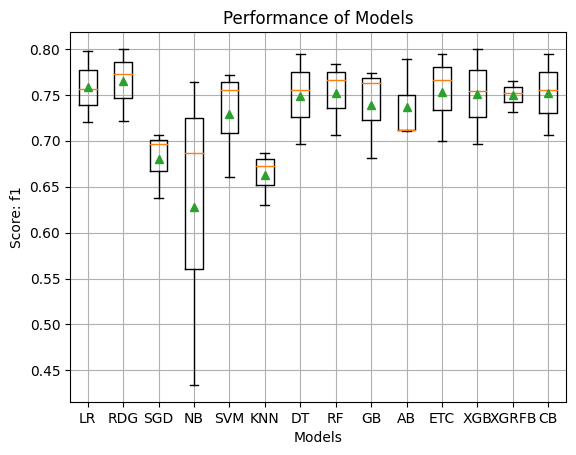

In [33]:
# direction forward
model_report = wrapper_obj.recursive_feature_selection(model_tags, True)

In [34]:
pd.DataFrame(model_report).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
1,Ridge Classifier,0.764664,0.032542,"[Name_Words, Name_Init_Capt, Name_Init_Col, Na...","[0.8, 0.7725321888412017, 0.7214611872146117]"
0,Logistic Regression,0.758469,0.031647,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun...","[0.7981651376146789, 0.7565217391304349, 0.720..."
10,Extra Tres Boosting,0.753493,0.039582,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun...","[0.7945205479452055, 0.7659574468085106, 0.7]"
13,Cat Boosting,0.751923,0.036268,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun...","[0.7945205479452055, 0.7553648068669527, 0.705..."
7,Random Forest,0.751750,0.033207,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun...","[0.7834101382488479, 0.7659574468085106, 0.705..."
11,Extra Gradient Boosting,0.750406,0.042212,"[Name_Init_labelencode, Name_Init_Capt, Name_I...","[0.8, 0.7543859649122807, 0.6968325791855204]"
12,Extra Random Forest Boosting,0.749800,0.013811,"[Name_Words, Name_Init_ordinalencode, Name_Ini...","[0.7524752475247524, 0.7652173913043477, 0.731..."
6,Decision Tree,0.748906,0.040142,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun...","[0.7945205479452055, 0.7553648068669527, 0.696..."
8,Gradient Boosting,0.739369,0.041049,"[Name_Length, Name_Init_Capt, Name_Init_Col, N...","[0.7733333333333334, 0.7631578947368421, 0.681..."
9,Ada Boosting,0.737215,0.036785,"[Name_Init_Capt, Name_Init_Countess, Name_Init...","[0.7892376681614349, 0.7112970711297071, 0.711..."


In [39]:
# models work with backward selection approach
model_tags = ["LR", "NB", 
            #   "SVM",  # taking so much of time
              "KNN", "DT", "RF", "GB", "AB", "ETC", "XGB", "XGRFB","CB"]

=============== Logistic Regression ===============
16 : Mean: 0.7587149793962936 Std: 0.03778673931182917

=============== Naive Bayes ===============
16 : Mean: 0.7382196873267867 Std: 0.04487647193297028

=============== K-Neighbors ===============
16 : Mean: 0.6783041929689619 Std: 0.04308995636777625

=============== Decision Tree ===============
16 : Mean: 0.7522064508679147 Std: 0.00836412498014925

=============== Random Forest ===============
16 : Mean: 0.7392621371989749 Std: 0.04275755493268837

=============== Gradient Boosting ===============
16 : Mean: 0.7579393746471098 Std: 0.016841854564243877

=============== Ada Boosting ===============
16 : Mean: 0.750905310951949 Std: 0.028369525812990272

=============== Extra Tres Boosting ===============
16 : Mean: 0.7148531417809263 Std: 0.015061470779876117

=============== Extra Gradient Boosting ===============
16 : Mean: 0.7368145743145743 Std: 0.016815939940327422

=============== Extra Random Forest Boosting =============

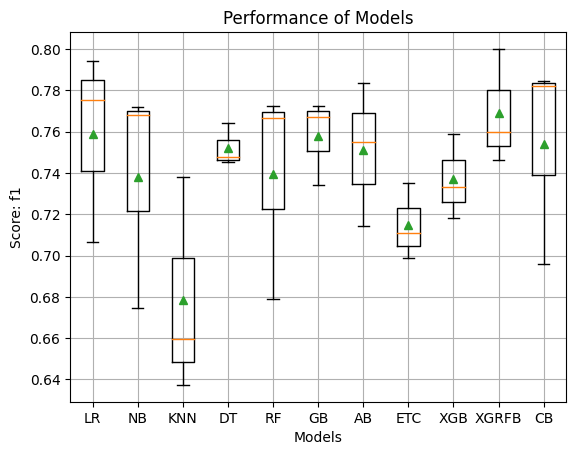

In [40]:
# direction backward
model_report1 = wrapper_obj.recursive_feature_selection(model_tags, True, "backward")

In [41]:
pd.DataFrame(model_report1).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
9,Extra Random Forest Boosting,0.768804,0.022746,"[Name_Init_ordinalencode, Name_Init_Don, Name_...","[0.7599999999999999, 0.8, 0.7464114832535885]"
0,Logistic Regression,0.758715,0.037787,"[Name_Words, Name_Init_ordinalencode, Name_Ini...","[0.7943925233644861, 0.7753303964757708, 0.706..."
5,Gradient Boosting,0.757939,0.016842,"[Name_Words, Name_Init_labelencode, Name_Init_...","[0.7722772277227723, 0.7672413793103448, 0.734..."
10,Cat Boosting,0.754205,0.041110,"[Name_Length, Name_Init_labelencode, Name_Init...","[0.7843137254901961, 0.7822222222222222, 0.696..."
3,Decision Tree,0.752206,0.008364,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7475728155339806, 0.7639484978540773, 0.745..."
6,Ada Boosting,0.750905,0.028370,"[Name_Words, Name_Length, Name_Init_Major, Nam...","[0.7834101382488479, 0.7550200803212852, 0.714..."
4,Random Forest,0.739262,0.042758,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7663551401869159, 0.7725321888412017, 0.678..."
1,Naive Bayes,0.738220,0.044876,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7719298245614035, 0.7679324894514769, 0.674..."
8,Extra Gradient Boosting,0.736815,0.016816,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7333333333333333, 0.7589285714285713, 0.718..."
7,Extra Tres Boosting,0.714853,0.015061,"[Name_Length, Name_Init_Col, Name_Init_Countes...","[0.7111111111111111, 0.7348837209302326, 0.698..."


### Backward Elimination: 
Start with all features and eliminate one at a time based on model performance.

In [42]:
wrapper_obj.rfe_model_tags

['LR', 'RDG', 'SGD', 'DT', 'RF', 'ETC', 'GB', 'SVM', 'XGB', 'XGRFB', 'CB']

=============== Logistic Regression ===============
22 : Mean: 0.7636573967698433 Std: 0.03316485756974777

=============== Ridge Classifier ===============
27 : Mean: 0.7638349796914471 Std: 0.040021550000228875

=============== Stocastic Gradient ===============
26 : Mean: 0.7612590372068418 Std: 0.03287613673201604

=============== Decision Tree ===============
10 : Mean: 0.6789999755315765 Std: 0.006758057423309829

=============== Random Forest ===============
7 : Mean: 0.7478558250266806 Std: 0.03079641576822752

=============== Extra Tres Boosting ===============
6 : Mean: 0.7269279393173198 Std: 0.01787880609826918

=============== Gradient Boosting ===============
5 : Mean: 0.7563037617048858 Std: 0.026534655803158017

=============== Support Vector ===============
14 : Mean: 0.7432192187669937 Std: 0.06069746674572214

=============== Extra Gradient Boosting ===============
9 : Mean: 0.7348391026685602 Std: 0.016694629895631585

=============== Extra Random Forest Boosting ==

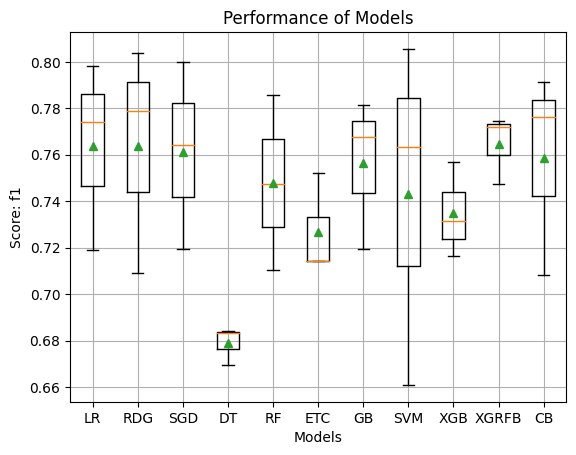

In [47]:
# backward feature elimination
model_report2 = wrapper_obj.backward_feature_elimination(wrapper_obj.rfe_model_tags, True)

In [48]:
pd.DataFrame(model_report2).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
9,Extra Random Forest Boosting,0.764671,0.012136,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7745098039215685, 0.7719298245614035, 0.747..."
1,Ridge Classifier,0.763835,0.040022,"[Name_Words, Name_Init_labelencode, Name_Init_...","[0.8036529680365297, 0.7787610619469025, 0.709..."
0,Logistic Regression,0.763657,0.033165,"[Name_Words, Name_Init_Capt, Name_Init_Don, Na...","[0.7981651376146789, 0.773913043478261, 0.7188..."
2,Stocastic Gradient,0.761259,0.032876,"[Name_Init_labelencode, Name_Init_Capt, Name_I...","[0.8, 0.7641509433962264, 0.719626168224299]"
10,Cat Boosting,0.758455,0.036105,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7761194029850746, 0.7911111111111111, 0.708..."
6,Gradient Boosting,0.756304,0.026535,"[Name_Init_ordinalencode, Name_Init_Mr, Pclass...","[0.7677725118483414, 0.7815126050420167, 0.719..."
4,Random Forest,0.747856,0.030796,"[Name_Length, Name_Init_ordinalencode, Name_In...","[0.7475728155339806, 0.7857142857142858, 0.710..."
7,Support Vector,0.743219,0.060697,"[Name_Init_Don, Name_Init_Jonkheer, Name_Init_...","[0.8055555555555555, 0.7631578947368421, 0.660..."
8,Extra Gradient Boosting,0.734839,0.016695,"[Name_Length, Name_Init_labelencode, Name_Init...","[0.7162790697674419, 0.7567567567567567, 0.731..."
5,Extra Tres Boosting,0.726928,0.017879,"[Name_Length, Name_Init_Mr, Sex_labelencode, P...","[0.7142857142857143, 0.7522123893805309, 0.714..."


## Embedded Methods

### Lasso Regression (L1 regularization): 
Penalize coefficients to zero, effectively performing feature selection.

In [ ]:
# this is a classifiaction problem can't proceeed with this

### Decision Trees/Random Forests: 
Feature importance from ensemble methods.

In [100]:
FEATURES = NUM_FATURES + CAT_FEATURES

In [102]:
# FEATURES

In [108]:
X = df[FEATURES]
y = df[TARGET_COL]

In [109]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X, y)

DecisionTreeClassifier()

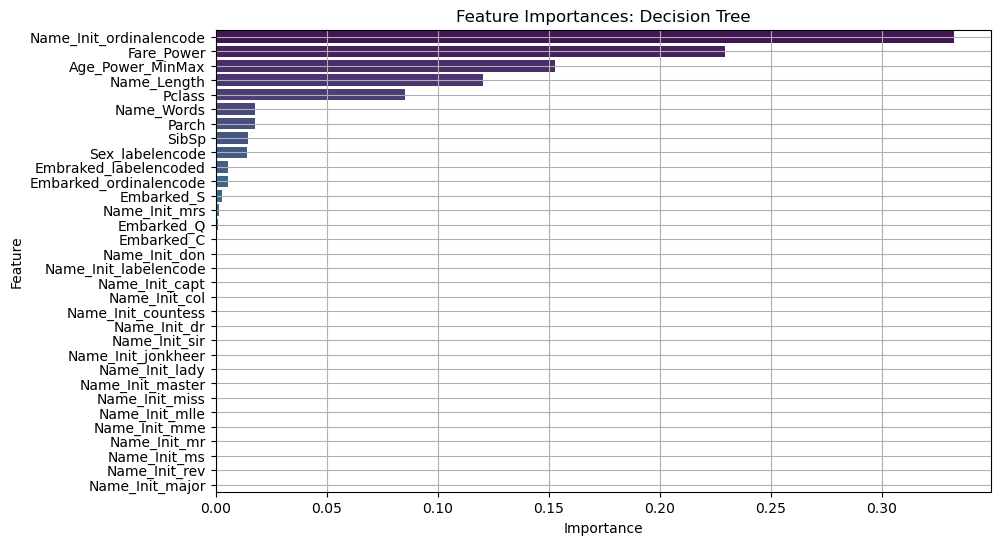

In [123]:
# collectign important features
importances = dt_model.feature_importances_
# Create a bar plot of feature importances
indices = np.argsort(importances)[::-1]
# Create a DataFrame for plotting
importance_df_dtree = pd.DataFrame({
    'Feature': np.array(FEATURES)[indices],
    'Importance': importances[indices]
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_dtree, palette='viridis')
plt.title('Feature Importances: Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

In [129]:
dtree_imp = importance_df_dtree[importance_df_dtree['Importance']>0]

DECISION_TREE_FEATURE_IMP = []
for i in dtree_imp['Feature']:
    DECISION_TREE_FEATURE_IMP.append(i)

In [131]:
print(DECISION_TREE_FEATURE_IMP)

['Name_Init_ordinalencode', 'Fare_Power', 'Age_Power_MinMax', 'Name_Length', 'Pclass', 'Name_Words', 'Parch', 'SibSp', 'Sex_labelencode', 'Embraked_labelencoded', 'Embarked_ordinalencode', 'Embarked_S', 'Name_Init_mrs', 'Embarked_Q', 'Embarked_C']


In [124]:
# random forest
rf_model=RandomForestClassifier(random_state=0)
rf_model.fit(X, y)

RandomForestClassifier(random_state=0)

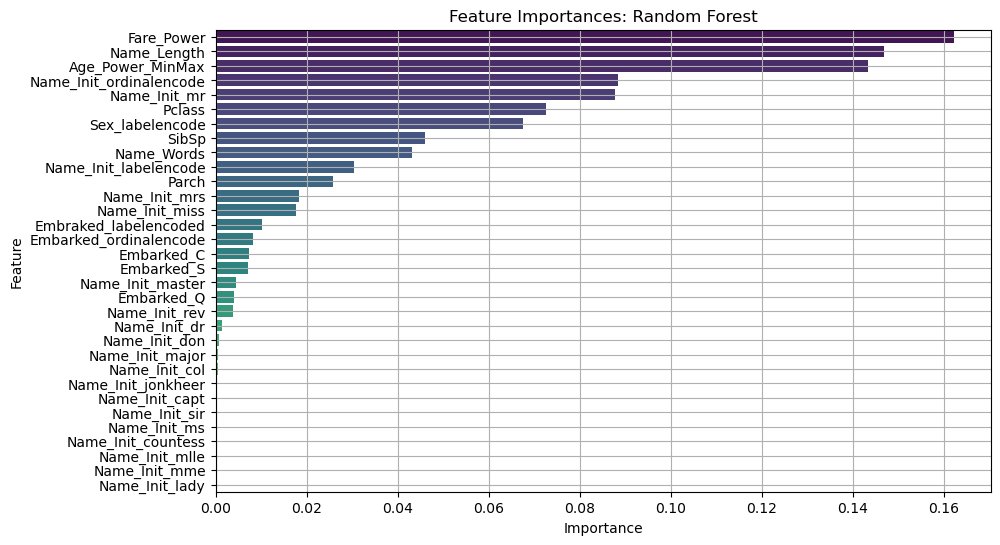

In [132]:
# collectign important features
importances = rf_model.feature_importances_
# Create a bar plot of feature importances
indices = np.argsort(importances)[::-1]
# Create a DataFrame for plotting
importance_rf = pd.DataFrame({
    'Feature': np.array(FEATURES)[indices],
    'Importance': importances[indices]
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf, palette='viridis')
plt.title('Feature Importances: Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

In [133]:
rf_imp = importance_rf[importance_rf['Importance']>0]

RANDOM_FOREST_FEATURE_IMP = []
for i in rf_imp['Feature']:
    RANDOM_FOREST_FEATURE_IMP.append(i)

In [134]:
print(RANDOM_FOREST_FEATURE_IMP)

['Fare_Power', 'Name_Length', 'Age_Power_MinMax', 'Name_Init_ordinalencode', 'Name_Init_mr', 'Pclass', 'Sex_labelencode', 'SibSp', 'Name_Words', 'Name_Init_labelencode', 'Parch', 'Name_Init_mrs', 'Name_Init_miss', 'Embraked_labelencoded', 'Embarked_ordinalencode', 'Embarked_C', 'Embarked_S', 'Name_Init_master', 'Embarked_Q', 'Name_Init_rev', 'Name_Init_dr', 'Name_Init_don', 'Name_Init_major', 'Name_Init_col', 'Name_Init_jonkheer', 'Name_Init_capt', 'Name_Init_sir', 'Name_Init_ms', 'Name_Init_countess', 'Name_Init_mlle', 'Name_Init_mme', 'Name_Init_lady']


## Dimensionality Reduction

In [95]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,cross_val_score

In [84]:
pca_df = df[NUM_FATURES+CAT_FEATURES].copy()

In [85]:
pca = PCA()
pca_features = pca.fit_transform(pca_df)

In [86]:
PCA_DF = pd.DataFrame(pca_features, columns=["PC"+str(i) for i in range(pca_df.shape[1])])

In [87]:
PCA_DF.shape

(891, 32)

In [88]:
list_of_variance = pca.explained_variance_ratio_
list_of_variance.sort()

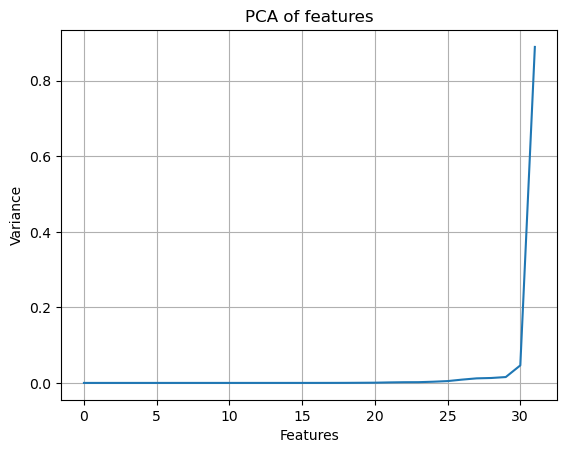

In [89]:
plt.plot(list_of_variance)
plt.xlabel("Features")
plt.ylabel("Variance")
plt.title("PCA of features")
plt.grid()
plt.show()

In [91]:
sum(list_of_variance[31:])

0.8895025503992456

In [93]:
model = RandomForestClassifier()
model.fit(PCA_DF, df[TARGET_COL])

RandomForestClassifier()

In [96]:
scores = cross_val_score(RandomForestClassifier(),X=PCA_DF, y=df[TARGET_COL],
                cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),scoring='f1')

In [98]:
np.mean(scores), np.std(scores)

(0.7466838522364362, 0.03844147578033011)